In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
from IPython.display import display, Latex
import pycbc
from pycbc.waveform import get_td_waveform, get_fd_waveform
from scipy.interpolate import interp1d
import sys
sys.path.append('/home/anirudh.nemmani/git_repos/teobresums/Python/') #TEOBResumS module path
import EOBRun_module
sys.path.append('/home/anirudh.nemmani/git_repos/gweat/src/') #GWEAT module path
import TEOBResumS_utils as ecc_gen
import eccentric_source as ecc_sou
from pesummary.io import read

sys.path.append('/home/anirudh.nemmani/git_repos/GWMAT/src/') # GWMAT module path
import py_lgw
lgw = py_lgw.lensed_wf_gen()

In [2]:
def match(wf1, wf2, f_low=20, f_high=1024, psd_path='/home/anirudh.nemmani/Projects/isolated-versus-strong/data/psd_aLIGO_O4high.txt'):
    flen= max(len(wf1), len(wf2))
    wf1.resize(flen)
    wf2.resize(flen)
    
    delta_f = wf1.delta_f
    psd = pycbc.psd.from_txt(psd_path, flen, delta_f, f_low, is_asd_file=False)
    return pycbc.filter.matchedfilter.match(wf1, wf2, psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)

In [3]:
# Reading GW150914 parameters

gw150914 = read('/home/anirudh.nemmani/Projects/isolated-versus-strong/data/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5') # Path to GWTC posterior samples
gw150914_result = gw150914.samples_dict['C01:IMRPhenomXPHM']
gw150914_pe_res = dict()
idx = np.argmax(gw150914_result['log_likelihood'])
for key in gw150914_result.keys():
            val = gw150914_result[key][idx]
            gw150914_pe_res[key] = np.float64(val)

2023-09-05  14:54:22 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2023-09-05  14:54:22 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2023-09-05  14:54:22 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default


In [4]:
# Converting j-frame to l-frame
# Tilts are taken to be zero which is default in GWMAT
spins = lgw.jframe_to_l0frame(gw150914_pe_res['mass_1'], gw150914_pe_res['mass_2'], 20, phi_ref=gw150914_pe_res['phase'], 
                             theta_jn = gw150914_pe_res['theta_jn'], phi_jl=gw150914_pe_res['phi_jl'],
                             a_1=gw150914_pe_res['a_1'], a_2=gw150914_pe_res['a_2'], phi_12 = gw150914_pe_res['phi_12'])

for keys in spins.keys():
    print('%s : %s'%(keys, spins[keys]))

inclination : 2.491015454676615
spin1x : -0.0
spin1y : 0.0
spin1z : 0.8608417198511092
spin2x : -0.0
spin2y : 0.0
spin2z : 0.7195088134379835


# Defining parameters for waveform generation

In [5]:
sampling_frequency = 4096
f_start = 8  # starting frequency of WF, i.e., (2,2) mode of the WF.
f_low = 20    # Lower frequency from where SNR will be computed. It should satisfy the condition, f_start <= f_low, for it to make sense.
f_ref = 20.
f_high = None
# df = 0.007768570860783086 
init_pars = dict(f_start=f_start, f_low=f_low, f_high=f_high, f_ref=f_ref, sample_rate=sampling_frequency, ifo_list=['H1','L1'], wf_approximant='IMRPhenomXPHM')

cbc_pars = dict(mass_1=gw150914_pe_res['mass_1'], mass_2=gw150914_pe_res['mass_2'], chi1z=0, chi2z=0, 
              inclination=spins['inclination'], coa_phase=gw150914_pe_res['phase'], polarization=gw150914_pe_res['psi'], ra=gw150914_pe_res['ra'], dec=gw150914_pe_res['dec'], 
              luminosity_distance=gw150914_pe_res['luminosity_distance'], trigger_time=gw150914_pe_res['geocent_time'],
              ecc=0.2)
#psd_pars = dict(Noise=False, gen_seed=10, psd_L1='O4')

prms = {**init_pars, **cbc_pars}#, **psd_pars
pars = ecc_gen.teobresums_pars_update(prms)

# Generating non-eccentric waveform using the approximant IMRPhenomXPHM, to have it as a basline

In [6]:
# generating a waveform of same df to check the interpolation
f_hp_001, f_hc_001 = get_fd_waveform(
            approximant = pars['wf_approximant'],
            mass1 = pars['mass_1'],
            mass2 = pars['mass_2'],
            spin1x = 0,
            spin1y = 0,
            spin1z = 0,
            spin2x = 0,
            spin2y = 0,
            spin2z = 0,
            lambda1 = 0,
            lambda2 = 0,
            distance =  pars['luminosity_distance'],
            inclination = pars['inclination'],
            coa_phase = pars['coa_phase'],
            mode_array = pars['mode_array'],
            f_lower = pars['f_low'],
            f_ref = pars['f_ref'],
            delta_f = 0.01)

#Frequency vector for interpolation
frequency_vector = np.arange(0, 1024, 0.01)

# Generating waveform to interpolate
t_hp, t_hc = get_td_waveform(
            approximant = pars['wf_approximant'],
            mass1 = pars['mass_1'],
            mass2 = pars['mass_2'],
            spin1x = 0,
            spin1y = 0,
            spin1z = 0,
            spin2x = 0,
            spin2y = 0,
            spin2z = 0,
            lambda1 = 0,
            lambda2 = 0,
            distance =  pars['luminosity_distance'],
            inclination = pars['inclination'],
            coa_phase = pars['coa_phase'],
            mode_array = pars['mode_array'],
            f_lower = pars['f_low'],
            f_ref = pars['f_ref'],
            delta_t = 1./pars['sample_rate'])

f_hp = t_hp.to_frequencyseries(delta_f=t_hp.delta_f)
f_hc = t_hc.to_frequencyseries(delta_f=t_hc.delta_f)

In [7]:
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)


sub_figure_1 = fig.add_subplot(2,2,(1, 2)) # two rows, two columns, first and second cell
sub_figure_1.plot(t_hp.sample_times, t_hp, label=r'$h_{+}$')
sub_figure_1.plot(t_hc.sample_times, t_hc, label=r'$h_{\times}$')
sub_figure_1.set_title(r'Time Series plot')
sub_figure_1.set_xlabel(r'Times ($s$)')
sub_figure_1.set_xlim(-1.5, 0.5)
sub_figure_1.set_ylabel(r'Strain ($h$)')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(2,2,3) # two rows, two columns, third cell
sub_figure_2.loglog(f_hp.sample_frequencies, np.abs(f_hp), label=r'$h_{+}$')
sub_figure_2.loglog(f_hc.sample_frequencies, np.abs(f_hc), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Frequencies Series, absolute value plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,2,4) # two rows, two columns, fourth cell
sub_figure_3.plot(f_hp.sample_frequencies, np.angle(f_hp), label=r'$h_{+}$')
sub_figure_3.plot(f_hc.sample_frequencies, np.angle(f_hc), label=r'$h_{\times}$')
sub_figure_3.set_title(r'Frequencies Series, phase plot')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xscale('log')
sub_figure_3.set_xlim(20, 1024)
sub_figure_3.set_ylabel(r'Phase')
sub_figure_3.legend()

plt.suptitle(r'Waveform plots of non spinning GW150914 non-eccentric waveform IMRPhenomXPHM')

Text(0.5, 0.98, 'Waveform plots of non spinning GW150914 non-eccentric waveform IMRPhenomXPHM')

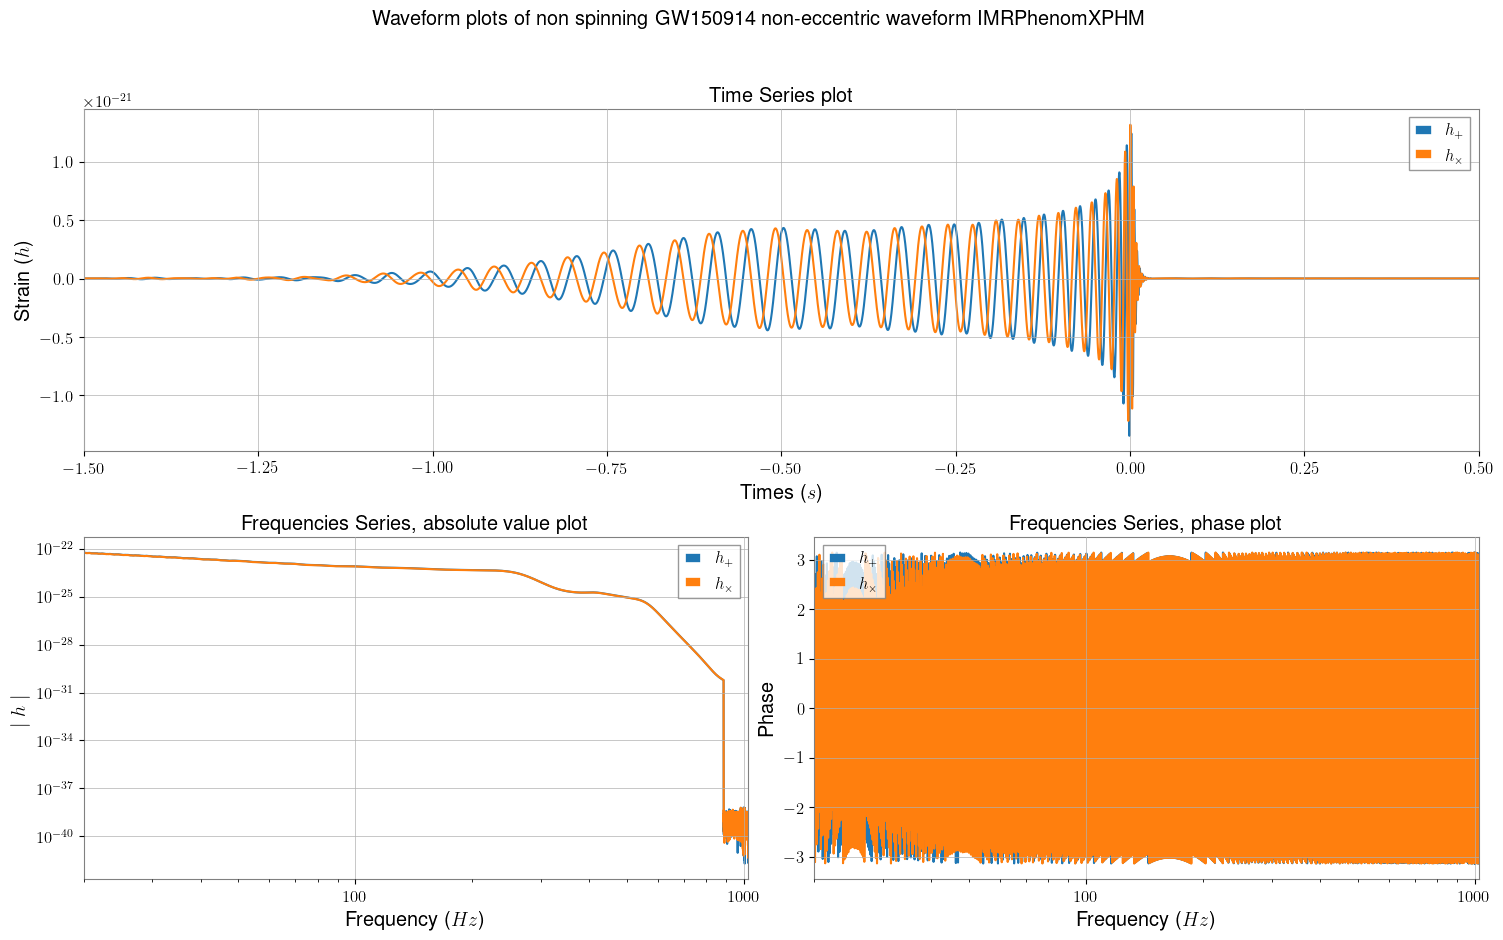

In [8]:
plt.show()

<font size="5"> Let's interpolate the frequency series with just normal strain and frequency array </font>

In [9]:
strain_array_hp = np.array(f_hp, dtype=np.complex128)
strain_array_hc = np.array(f_hc, dtype=np.complex128)

Interpolating function

In [10]:
if_hp = interp1d(f_hp.sample_frequencies[:], strain_array_hp[:], kind='linear')
if_hc = interp1d(f_hc.sample_frequencies[:], strain_array_hc[:], kind='linear')

Interpolating to the new frequency vector and concating it

In [11]:
interpolated_hp = np.concatenate(([0], if_hp(frequency_vector[1:])))
interpolated_hc = np.concatenate(([0], if_hc(frequency_vector[1:])))

In [12]:
frequency_bounds = (frequency_vector >=frequency_vector[0]) * (frequency_vector <= frequency_vector[-1])
interpolated_hp *= frequency_bounds
interpolated_hc *= frequency_bounds

In [13]:
interpolated_pycbc_hp =  pycbc.types.frequencyseries.FrequencySeries(interpolated_hp, delta_f=0.01)
interpolated_pycbc_hc =  pycbc.types.frequencyseries.FrequencySeries(interpolated_hc, delta_f=0.01)

In [14]:
print("The match between the (plus) interpolated waveform and the generated waveform is ", match(interpolated_pycbc_hp, f_hp_001)[0])
print("The match between the (cross) interpolated waveform and the generated waveform is ", match(interpolated_pycbc_hc, f_hc_001)[0])

The match between the (plus) interpolated waveform and the generated waveform is  0.9985933014324484
The match between the (cross) interpolated waveform and the generated waveform is  0.9985903482692005


In [15]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_1 = fig.add_subplot(1,2,1)
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_hp), label=r'$h_{+}$')
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_hc), label=r'$h_{\times}$')
sub_figure_1.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(1,2,2)
sub_figure_2.plot(frequency_vector, np.angle(interpolated_hp), label=r'$h_{+}$')
sub_figure_2.plot(frequency_vector, np.angle(interpolated_hc), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xscale('log')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'Phase')
sub_figure_2.legend()

plt.suptitle(r'Interpolated waveform plots of non spinning GW150914 IMRPhenomXPHM waveform')

Text(0.5, 0.98, 'Interpolated waveform plots of non spinning GW150914 IMRPhenomXPHM waveform')

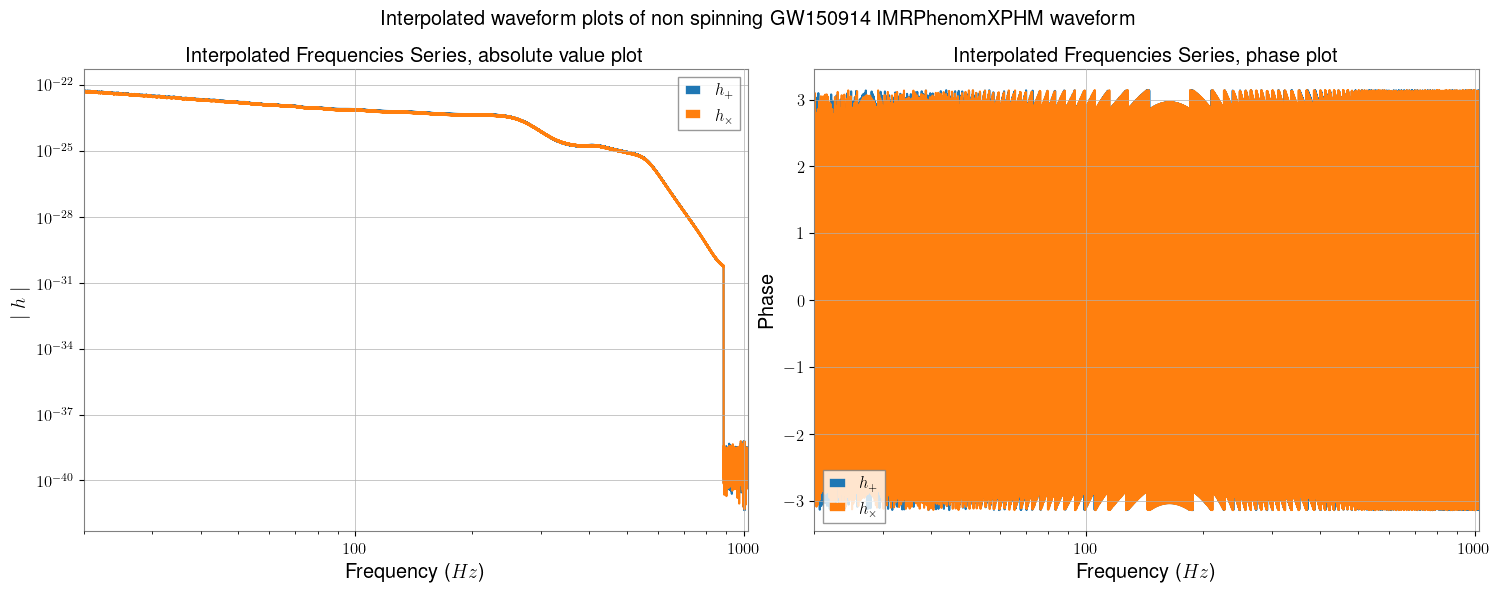

In [16]:
plt.show()

# Let's do the same interpolation in log series strain

In [17]:
log_strain_array_hp = np.log10(np.array(f_hp, dtype=np.complex128))
log_strain_array_hc = np.log10(np.array(f_hc, dtype=np.complex128))

/tmp/ipykernel_11001/752853974.py:1: RuntimeWarning: divide by zero encountered in log10
  log_strain_array_hp = np.log10(np.array(f_hp, dtype=np.complex128))
/tmp/ipykernel_11001/752853974.py:2: RuntimeWarning: divide by zero encountered in log10
  log_strain_array_hc = np.log10(np.array(f_hc, dtype=np.complex128))


In [18]:
log_if_hp = interp1d(f_hp.sample_frequencies[:], log_strain_array_hp[:], kind='linear')
log_if_hc = interp1d(f_hc.sample_frequencies[:], log_strain_array_hc[:], kind='linear')

In [19]:
interpolated_log_hp = np.concatenate(([0], 10**log_if_hp(frequency_vector[1:])))
interpolated_log_hc = np.concatenate(([0], 10**log_if_hc(frequency_vector[1:])))

In [20]:
frequency_bounds = (frequency_vector >=frequency_vector[0]) * (frequency_vector <= frequency_vector[-1])
interpolated_log_hp *= frequency_bounds
interpolated_log_hc *= frequency_bounds

In [21]:
interpolated_log_pycbc_hp =  pycbc.types.frequencyseries.FrequencySeries(interpolated_log_hp, delta_f=0.01)
interpolated_log_pycbc_hc =  pycbc.types.frequencyseries.FrequencySeries(interpolated_log_hc, delta_f=0.01)

In [22]:
print("The match between the (plus) interpolated waveform and the generated waveform is ", match(interpolated_log_pycbc_hp, f_hp_001)[0])
print("The match between the (cross) interpolated waveform and the generated waveform is ", match(interpolated_log_pycbc_hc, f_hc_001)[0])

The match between the (plus) interpolated waveform and the generated waveform is  0.8414493132488184
The match between the (cross) interpolated waveform and the generated waveform is  0.8415500661755134


The match is not good!!

In [23]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_1 = fig.add_subplot(1,2,1)
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_log_hp), label=r'$h_{+}$')
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_log_hc), label=r'$h_{\times}$')
sub_figure_1.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(1,2,2)
sub_figure_2.plot(frequency_vector, np.angle(interpolated_log_hp), label=r'$h_{+}$')
sub_figure_2.plot(frequency_vector, np.angle(interpolated_log_hc), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xscale('log')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'Phase')
sub_figure_2.legend()

plt.suptitle(r'Log strain interpolated waveform plots of non spinning GW150914 IMRPhenomXPHM waveform')

Text(0.5, 0.98, 'Log strain interpolated waveform plots of non spinning GW150914 IMRPhenomXPHM waveform')

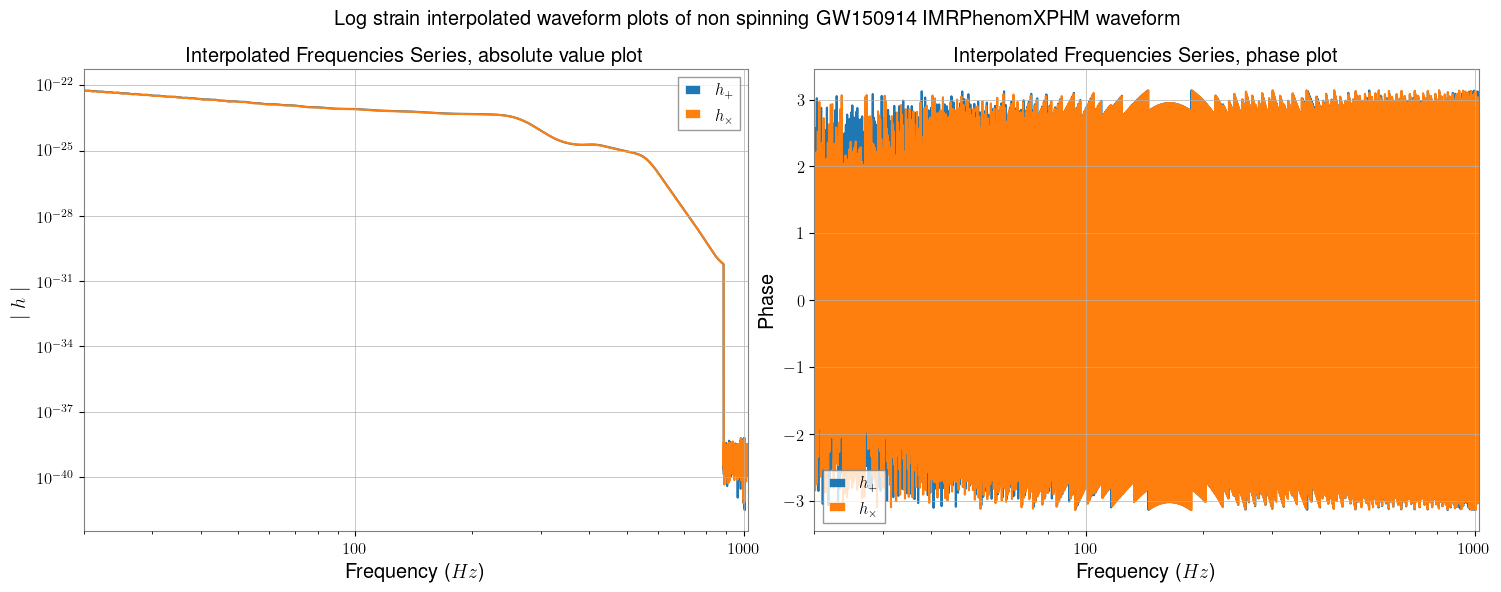

In [24]:
plt.show()

# Let's see if we still see the spurious behaviour of phase in both the interpolations, if we do see it then the problem is not with just TEOBResumS.

# If we don't see this issue, there is a problem with interpolation of TEOBResumS

<font size="4"> Getting the antenna pattern functions from PyCBC </font>

In [25]:
from pycbc.detector import Detector
fp, fc = Detector('L1').antenna_pattern(pars['ra'], pars['dec'], pars['polarization'], pars['trigger_time'])

In [26]:
display(Latex("Antenna pattern function values are : "))
display(Latex("$F_{+}$ = %s"%(fp)))
display(Latex("$F_{\\times}$ = %s"%(fc)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<font size="5"> Multiplying and adding the antenna pattern functions </font>

<font size="4">1. Normal Strain interpolation case </font>

In [27]:
proj_interpolated_hp = fp*interpolated_hp
proj_interpolated_hc = fc*interpolated_hc
tot_proj_interpolated = proj_interpolated_hp + proj_interpolated_hc

In [28]:
fig = plt.figure(figsize=(18, 10))
# plt.subplots_adjust(wspace= 0.1, hspace= 0.25)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

sub_figure_1 = fig.add_subplot(2,3,1)
sub_figure_1.loglog(frequency_vector, np.abs(proj_interpolated_hp), label=r'L1')
sub_figure_1.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()
# sub_figure_1.text(x = 0, y = 0, s = r'\textbf{Absolute value plots}', rotation=90)

sub_figure_2 = fig.add_subplot(2,3,2)
sub_figure_2.loglog(frequency_vector, np.abs(proj_interpolated_hc), label=r'L1')
sub_figure_2.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
# sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,3,3)
sub_figure_3.loglog(frequency_vector, np.abs(tot_proj_interpolated), label=r'L1')
sub_figure_3.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xlim(20, 1024)
# sub_figure_3.set_ylabel(r'$\mid h \mid$')
sub_figure_3.legend()

sub_figure_4 = fig.add_subplot(2,3,4)
sub_figure_4.plot(frequency_vector, np.angle(proj_interpolated_hp), label=r'L1')
sub_figure_4.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_4.set_xlabel(r'Frequency ($Hz$)')
sub_figure_4.set_xscale('log')
sub_figure_4.set_xlim(20, 1024)
sub_figure_4.set_ylabel(r'Phase')
sub_figure_4.legend()
# sub_figure_4.text(x = 0, y = 0, s = r'\textbf{Phase value plots}', rotation=90)

sub_figure_5 = fig.add_subplot(2,3,5)
sub_figure_5.plot(frequency_vector, np.angle(proj_interpolated_hc), label=r'L1')
sub_figure_5.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_5.set_xlabel(r'Frequency ($Hz$)')
sub_figure_5.set_xscale('log')
sub_figure_5.set_xlim(20, 1024)
# sub_figure_5.set_ylabel(r'Phase')
sub_figure_5.legend()

sub_figure_6 = fig.add_subplot(2,3,6)
sub_figure_6.plot(frequency_vector, np.angle(tot_proj_interpolated), label=r'L1')
sub_figure_6.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_6.set_xlabel(r'Frequency ($Hz$)')
sub_figure_6.set_xscale('log')
sub_figure_6.set_xlim(20, 1024)
# sub_figure_6.set_ylabel(r'Phase')
sub_figure_6.legend()

plt.suptitle(r'Projection plots of non spinning GW150914 interpolated IMRPhenomXPHM')
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

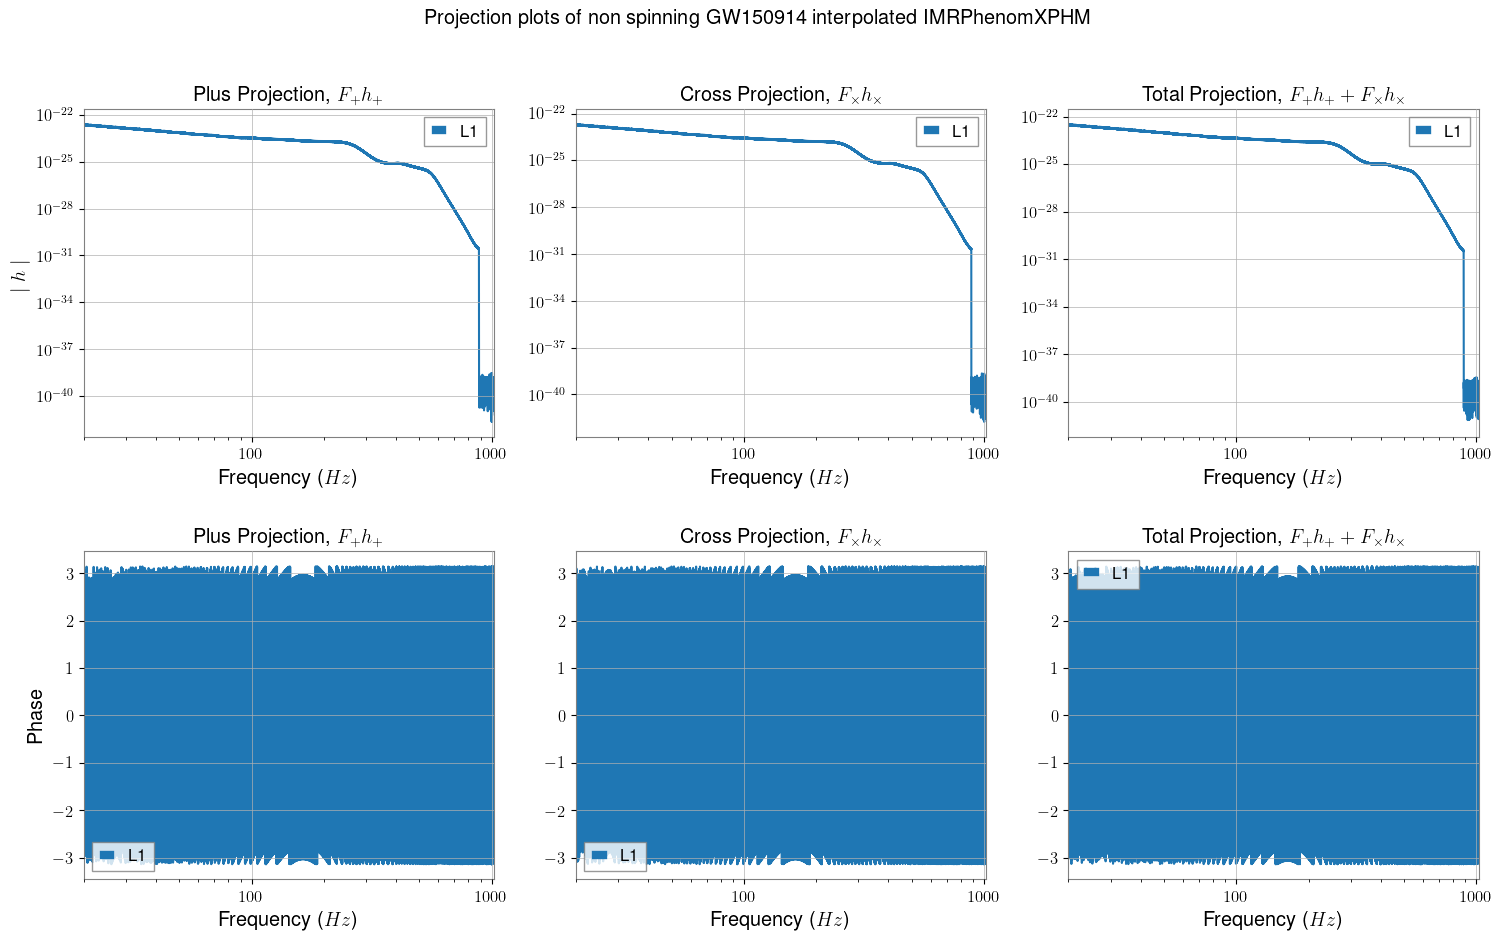

In [29]:
plt.show()

<font size="4">2. Log Strain interpolation case </font>

In [30]:
proj_interpolated_log_hp = fp*interpolated_log_hp
proj_interpolated_log_hc = fc*interpolated_log_hc
tot_proj_interpolated_log = proj_interpolated_log_hp + proj_interpolated_log_hc

In [31]:
fig = plt.figure(figsize=(18, 10))
# plt.subplots_adjust(wspace= 0.1, hspace= 0.25)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

sub_figure_1 = fig.add_subplot(2,3,1)
sub_figure_1.loglog(frequency_vector, np.abs(proj_interpolated_log_hp), label=r'L1')
sub_figure_1.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()
# sub_figure_1.text(x = 0, y = 0, s = r'\textbf{Absolute value plots}', rotation=90)

sub_figure_2 = fig.add_subplot(2,3,2)
sub_figure_2.loglog(frequency_vector, np.abs(proj_interpolated_log_hc), label=r'L1')
sub_figure_2.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
# sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,3,3)
sub_figure_3.loglog(frequency_vector, np.abs(tot_proj_interpolated_log), label=r'L1')
sub_figure_3.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xlim(20, 1024)
# sub_figure_3.set_ylabel(r'$\mid h \mid$')
sub_figure_3.legend()

sub_figure_4 = fig.add_subplot(2,3,4)
sub_figure_4.plot(frequency_vector, np.angle(proj_interpolated_log_hp), label=r'L1')
sub_figure_4.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_4.set_xlabel(r'Frequency ($Hz$)')
sub_figure_4.set_xscale('log')
sub_figure_4.set_xlim(20, 1024)
sub_figure_4.set_ylabel(r'Phase')
sub_figure_4.legend()
# sub_figure_4.text(x = 0, y = 0, s = r'\textbf{Phase value plots}', rotation=90)

sub_figure_5 = fig.add_subplot(2,3,5)
sub_figure_5.plot(frequency_vector, np.angle(proj_interpolated_log_hc), label=r'L1')
sub_figure_5.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_5.set_xlabel(r'Frequency ($Hz$)')
sub_figure_5.set_xscale('log')
sub_figure_5.set_xlim(20, 1024)
# sub_figure_5.set_ylabel(r'Phase')
sub_figure_5.legend()

sub_figure_6 = fig.add_subplot(2,3,6)
sub_figure_6.plot(frequency_vector, np.angle(tot_proj_interpolated_log), label=r'L1')
sub_figure_6.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_6.set_xlabel(r'Frequency ($Hz$)')
sub_figure_6.set_xscale('log')
sub_figure_6.set_xlim(20, 1024)
# sub_figure_6.set_ylabel(r'Phase')
sub_figure_6.legend()

plt.suptitle(r'Projection plots of non spinning GW150914 log interpolated IMRPhenomXPHM')
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

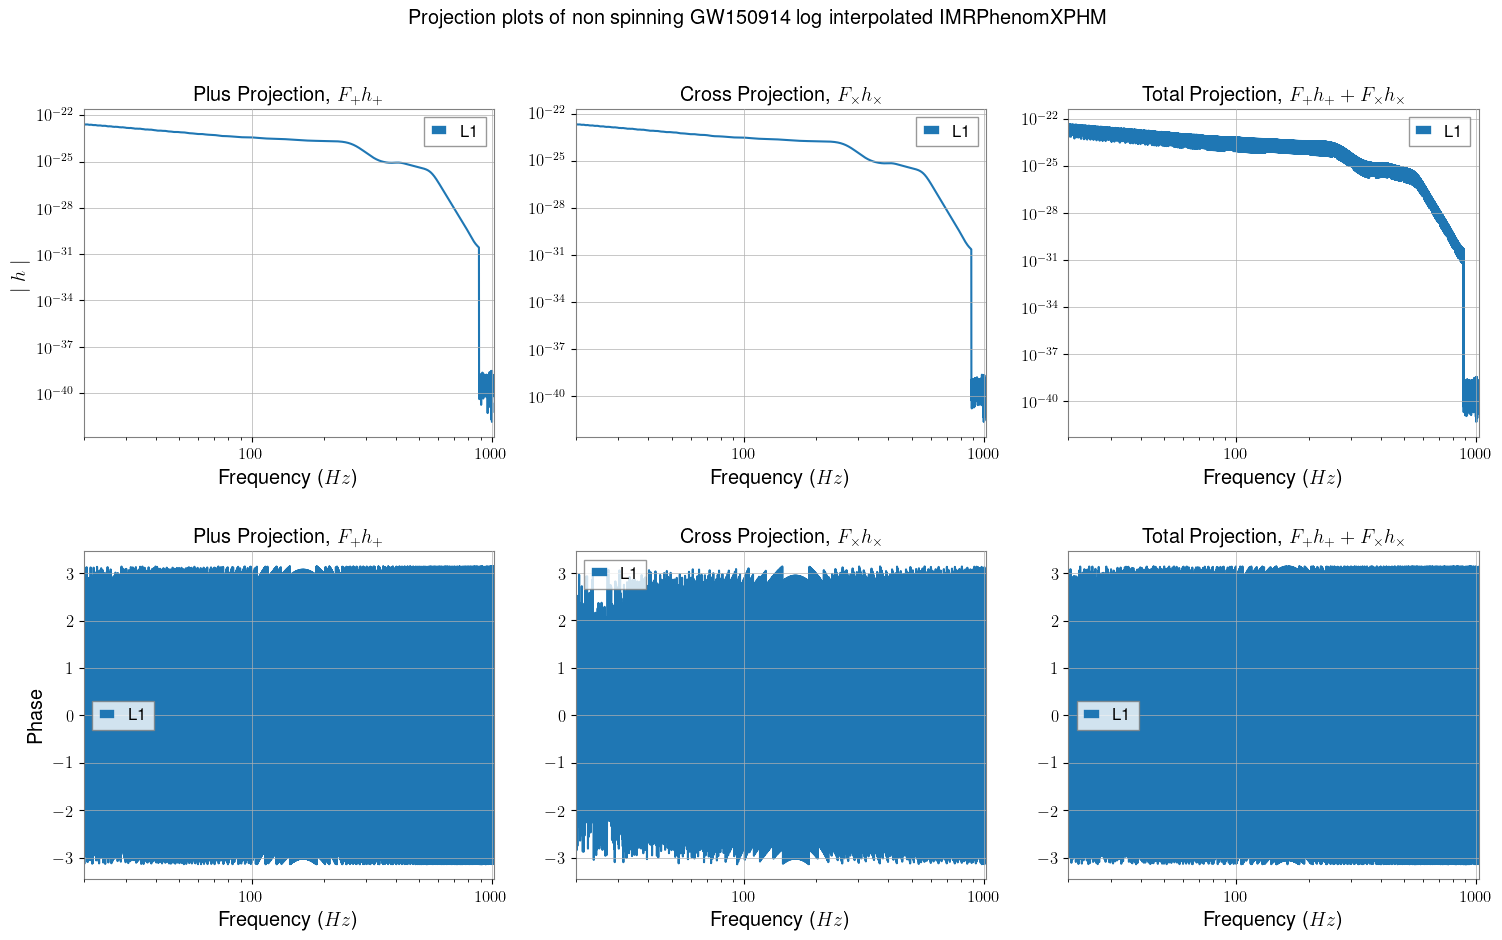

In [32]:
plt.show()

# Let's do the interpolation of normal strain, but in polar co-ordinates

<font size="3.5">
    Interpolation in polar co-ordinates as in, suppose we have a waveform of strain $h$. The waveform can be written as a function of frequency $h(f)$.<br>Since the waveform is a complex series, we can write it as follows <br> $h(f)$ = $\mathscr{R}(f)e^{i\mathscr{P}(f)}$ <br> We will interpolate the absolute value $\mathscr{R}(f)$ and phase $\mathscr{P}(f)$ given an frequency vector.
</font>

In [33]:
strain_array_hp = np.array(f_hp, dtype=np.complex128)
strain_array_hc = np.array(f_hc, dtype=np.complex128)

In [34]:
# Absolute strain series
abs_strain_hp = np.abs(strain_array_hp)
abs_strain_hc = np.abs(strain_array_hc)

# Phase series
phase_strain_hp = np.angle(strain_array_hp)
phase_strain_hc = np.angle(strain_array_hc)

In [35]:
if_abs_hp = interp1d(f_hp.sample_frequencies[:], abs_strain_hp[:], kind='linear')
if_abs_hc = interp1d(f_hc.sample_frequencies[:], abs_strain_hc[:], kind='linear')

if_phase_hp = interp1d(f_hp.sample_frequencies[:], phase_strain_hp[:], kind='linear')
if_phase_hc = interp1d(f_hc.sample_frequencies[:], phase_strain_hc[:], kind='linear')

In [36]:
interpolated_abs_hp = np.concatenate(([0], if_abs_hp(frequency_vector[1:])))
interpolated_abs_hc = np.concatenate(([0], if_abs_hc(frequency_vector[1:])))

interpolated_phase_hp = np.concatenate(([0], if_phase_hp(frequency_vector[1:])))
interpolated_phase_hc = np.concatenate(([0], if_phase_hc(frequency_vector[1:])))

In [37]:
interpolated_polar_hp = interpolated_abs_hp*np.exp(1j*interpolated_phase_hp)
interpolated_polar_hc = interpolated_abs_hc*np.exp(1j*interpolated_phase_hc)

In [38]:
frequency_bounds = (frequency_vector >=frequency_vector[0]) * (frequency_vector <= frequency_vector[-1])
interpolated_polar_hp *= frequency_bounds
interpolated_polar_hp *= frequency_bounds

Let's plot them and check

In [39]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_1 = fig.add_subplot(1,2,1)
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_polar_hp), label=r'$h_{+}$')
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_polar_hp), label=r'$h_{\times}$')
sub_figure_1.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(1,2,2)
sub_figure_2.plot(frequency_vector, np.angle(interpolated_polar_hp), label=r'$h_{+}$')
sub_figure_2.plot(frequency_vector, np.angle(interpolated_polar_hp), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xscale('log')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'Phase')
sub_figure_2.legend()

plt.suptitle(r'Interpolated waveform using absolute and phase series of non spinning GW150914 IMRPhenomXPHM waveform')

Text(0.5, 0.98, 'Interpolated waveform using absolute and phase series of non spinning GW150914 IMRPhenomXPHM waveform')

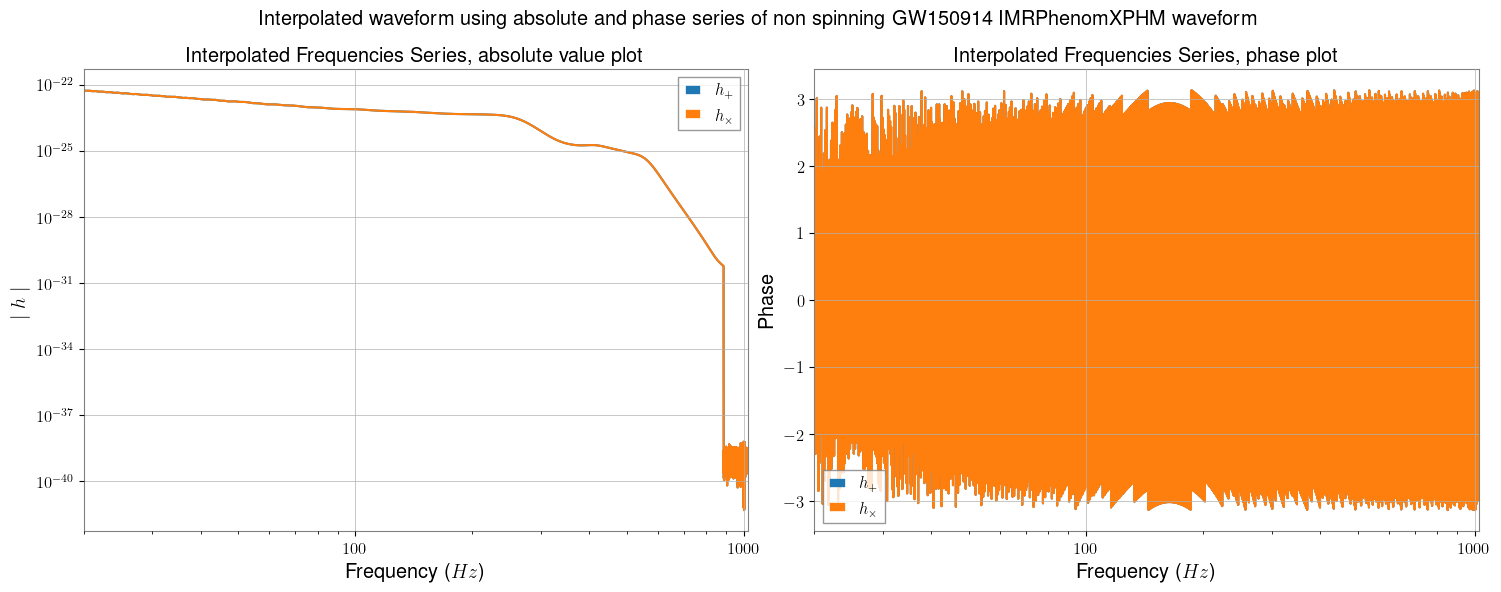

In [40]:
plt.show()

<font size="5"> Checking the match between the two waveforms </font>

In [41]:
interpolated_polar_pycbc_hp =  pycbc.types.frequencyseries.FrequencySeries(interpolated_polar_hp, delta_f=0.01)
interpolated_polar_pycbc_hc =  pycbc.types.frequencyseries.FrequencySeries(interpolated_polar_hc, delta_f=0.01)

In [42]:
print("The match between the (plus) interpolated waveform and the generated waveform is ", match(interpolated_polar_pycbc_hp, f_hp_001)[0])
print("The match between the (cross) interpolated waveform and the generated waveform is ", match(interpolated_polar_pycbc_hc, f_hc_001)[0])

The match between the (plus) interpolated waveform and the generated waveform is  0.8414493043838185
The match between the (cross) interpolated waveform and the generated waveform is  0.8415500569494868


This also have a bad match same as the log interpolation!!

Let's check the projection for this type of interpolation

In [43]:
proj_interpolated_polar_hp = fp*interpolated_polar_hp
proj_interpolated_polar_hc = fc*interpolated_polar_hc
tot_proj_interpolated_polar = proj_interpolated_polar_hp + proj_interpolated_polar_hc

In [44]:
fig = plt.figure(figsize=(18, 10))
# plt.subplots_adjust(wspace= 0.1, hspace= 0.25)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

sub_figure_1 = fig.add_subplot(2,3,1)
sub_figure_1.loglog(frequency_vector, np.abs(proj_interpolated_polar_hp), label=r'L1')
sub_figure_1.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()
# sub_figure_1.text(x = 0, y = 0, s = r'\textbf{Absolute value plots}', rotation=90)

sub_figure_2 = fig.add_subplot(2,3,2)
sub_figure_2.loglog(frequency_vector, np.abs(proj_interpolated_polar_hc), label=r'L1')
sub_figure_2.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
# sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,3,3)
sub_figure_3.loglog(frequency_vector, np.abs(tot_proj_interpolated_polar), label=r'L1')
sub_figure_3.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xlim(20, 1024)
# sub_figure_3.set_ylabel(r'$\mid h \mid$')
sub_figure_3.legend()

sub_figure_4 = fig.add_subplot(2,3,4)
sub_figure_4.plot(frequency_vector, np.angle(proj_interpolated_polar_hp), label=r'L1')
sub_figure_4.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_4.set_xlabel(r'Frequency ($Hz$)')
sub_figure_4.set_xscale('log')
sub_figure_4.set_xlim(20, 1024)
sub_figure_4.set_ylabel(r'Phase')
sub_figure_4.legend()
# sub_figure_4.text(x = 0, y = 0, s = r'\textbf{Phase value plots}', rotation=90)

sub_figure_5 = fig.add_subplot(2,3,5)
sub_figure_5.plot(frequency_vector, np.angle(proj_interpolated_polar_hc), label=r'L1')
sub_figure_5.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_5.set_xlabel(r'Frequency ($Hz$)')
sub_figure_5.set_xscale('log')
sub_figure_5.set_xlim(20, 1024)
# sub_figure_5.set_ylabel(r'Phase')
sub_figure_5.legend()

sub_figure_6 = fig.add_subplot(2,3,6)
sub_figure_6.plot(frequency_vector, np.angle(tot_proj_interpolated_polar), label=r'L1')
sub_figure_6.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_6.set_xlabel(r'Frequency ($Hz$)')
sub_figure_6.set_xscale('log')
sub_figure_6.set_xlim(20, 1024)
# sub_figure_6.set_ylabel(r'Phase')
sub_figure_6.legend()

plt.suptitle(r'Projection plots of non spinning GW150914 polar interpolated IMRPhenomXPHM')
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

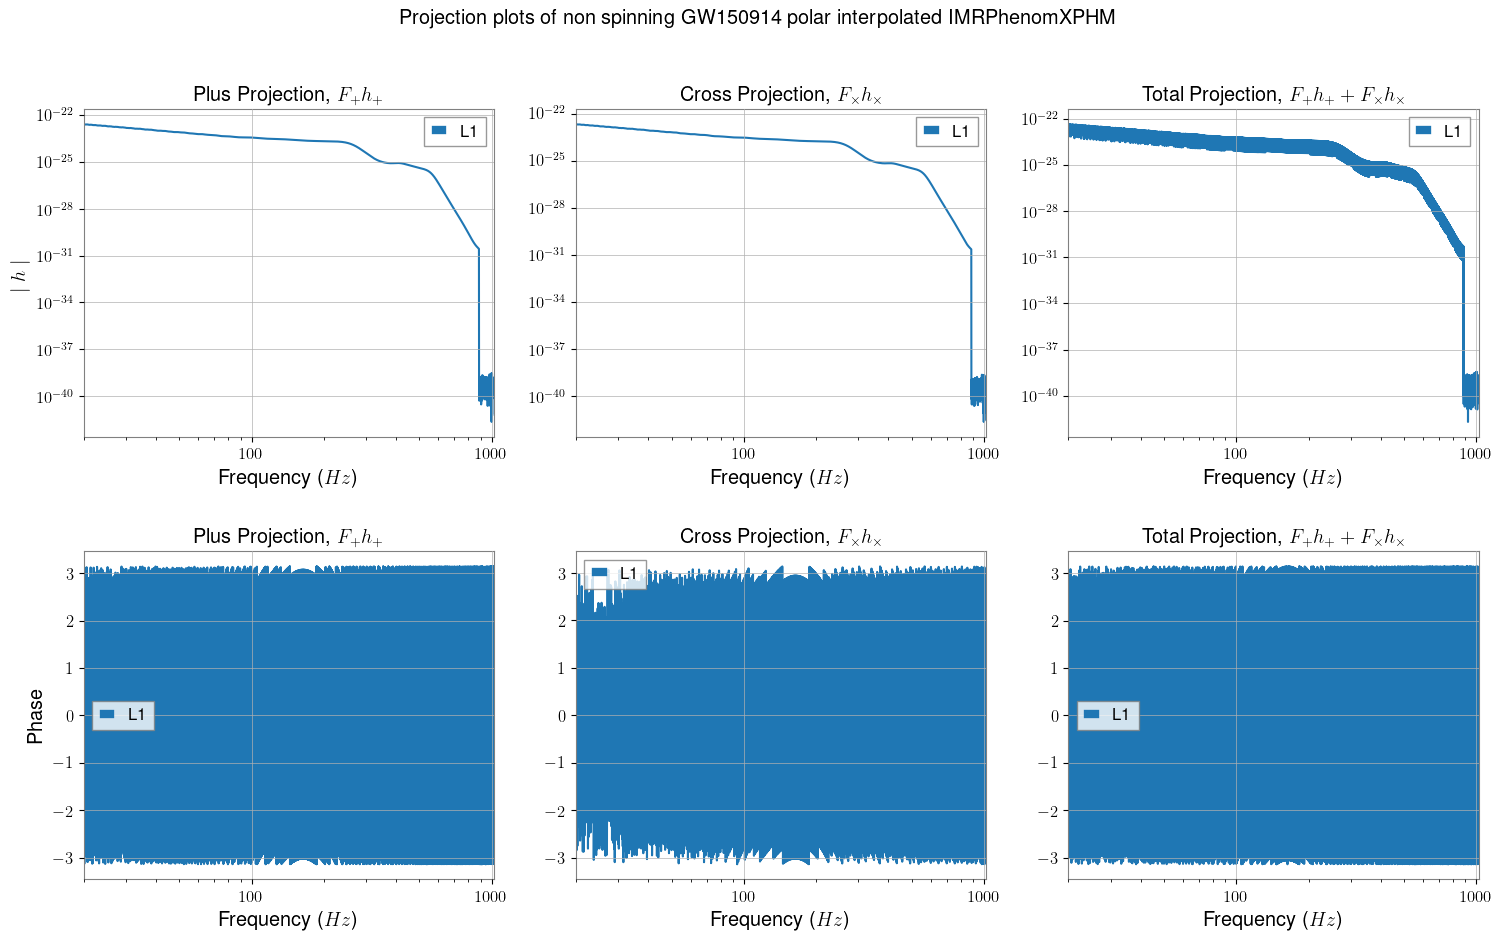

In [45]:
plt.show()

# The problem hasn't been resolved, it still exits. How about interpolation of phase using unwrapped phase.

In [46]:
strain_array_hp = np.array(f_hp, dtype=np.complex128)
strain_array_hc = np.array(f_hc, dtype=np.complex128)

In [47]:
# Absolute strain series
abs_strain_hp = np.abs(strain_array_hp)
abs_strain_hc = np.abs(strain_array_hc)

# Phase series
unwrapped_phase_hp = pycbc.waveform.utils.phase_from_frequencyseries(f_hp)
unwrapped_phase_hc = pycbc.waveform.utils.phase_from_frequencyseries(f_hc)
unwrapped_phase_strain_hp = np.array(unwrapped_phase_hp)
unwrapped_phase_strain_hc = np.array(unwrapped_phase_hc)

In [48]:
if_abs_hp = interp1d(f_hp.sample_frequencies[:], abs_strain_hp[:], kind='linear')
if_abs_hc = interp1d(f_hc.sample_frequencies[:], abs_strain_hc[:], kind='linear')

if_unwrapped_phase_hp = interp1d(f_hp.sample_frequencies[:], unwrapped_phase_strain_hp[:], kind='linear')
if_unwrapped_phase_hc = interp1d(f_hc.sample_frequencies[:], unwrapped_phase_strain_hc[:], kind='linear')

In [49]:
interpolated_abs_hp = np.concatenate(([0], if_abs_hp(frequency_vector[1:])))
interpolated_abs_hc = np.concatenate(([0], if_abs_hc(frequency_vector[1:])))

interpolated_unwrapped_phase_hp = np.concatenate(([0], if_unwrapped_phase_hp(frequency_vector[1:])))
interpolated_unwrapped_phase_hc = np.concatenate(([0], if_unwrapped_phase_hc(frequency_vector[1:])))

In [50]:
interpolated_unwrapped_polar_hp = interpolated_abs_hp*np.exp(1j*interpolated_unwrapped_phase_hp)
interpolated_unwrapped_polar_hc = interpolated_abs_hc*np.exp(1j*interpolated_unwrapped_phase_hc)

In [51]:
frequency_bounds = (frequency_vector >=frequency_vector[0]) * (frequency_vector <= frequency_vector[-1])
interpolated_unwrapped_polar_hp *= frequency_bounds
interpolated_unwrapped_polar_hp *= frequency_bounds

Let's plot them and check

In [52]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_1 = fig.add_subplot(1,2,1)
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_unwrapped_polar_hp), label=r'$h_{+}$')
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_unwrapped_polar_hp), label=r'$h_{\times}$')
sub_figure_1.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(1,2,2)
sub_figure_2.plot(frequency_vector, np.angle(interpolated_unwrapped_polar_hp), label=r'$h_{+}$')
sub_figure_2.plot(frequency_vector, np.angle(interpolated_unwrapped_polar_hp), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xscale('log')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'Phase')
sub_figure_2.legend()

plt.suptitle(r'Interpolated waveform using absolute and unwrapped phase series of non spinning GW150914 IMRPhenomXPHM waveform')

Text(0.5, 0.98, 'Interpolated waveform using absolute and unwrapped phase series of non spinning GW150914 IMRPhenomXPHM waveform')

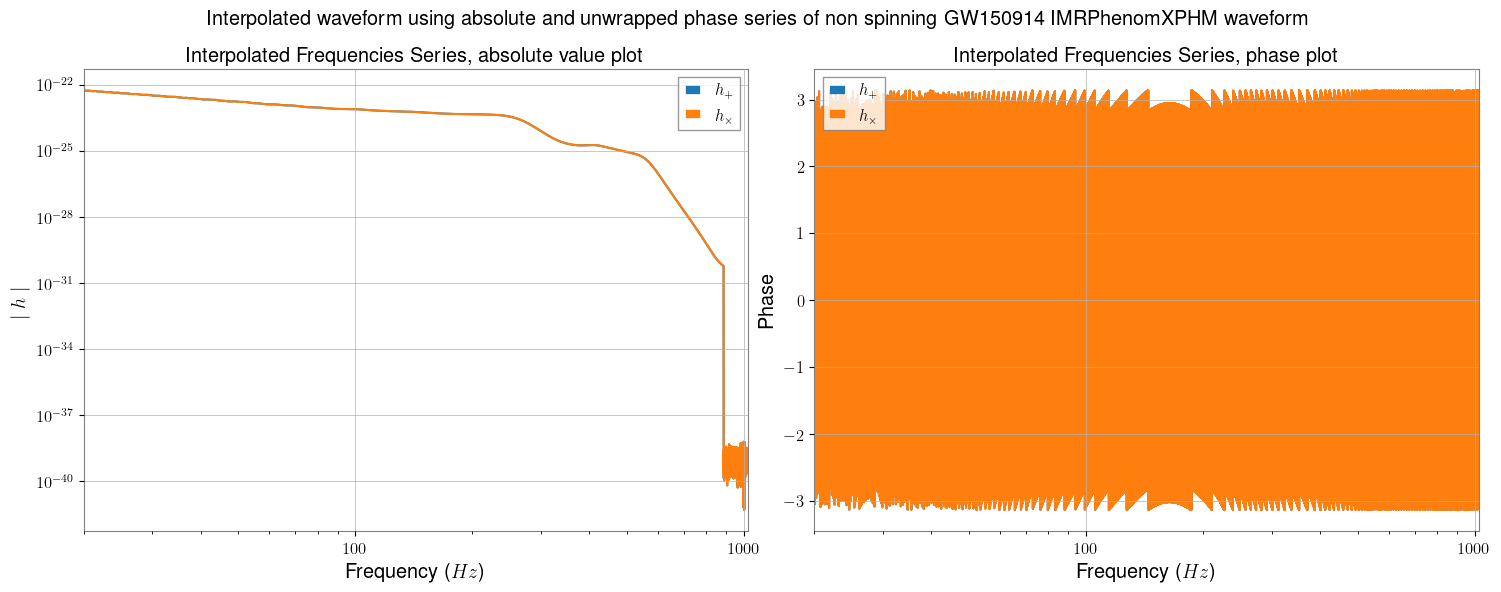

In [53]:
plt.show()

<font size="5"> Checking the match between the two waveforms </font>

In [54]:
interpolated_unwrapped_polar_pycbc_hp =  pycbc.types.frequencyseries.FrequencySeries(interpolated_unwrapped_polar_hp, delta_f=0.01)
interpolated_unwrapped_polar_pycbc_hc =  pycbc.types.frequencyseries.FrequencySeries(interpolated_unwrapped_polar_hc, delta_f=0.01)

In [55]:
print("The match between the (plus) interpolated waveform and the generated waveform is ", match(interpolated_unwrapped_polar_pycbc_hp, f_hp_001)[0])
print("The match between the (cross) interpolated waveform and the generated waveform is ", match(interpolated_unwrapped_polar_pycbc_hc, f_hc_001)[0])

The match between the (plus) interpolated waveform and the generated waveform is  0.9994600100470338
The match between the (cross) interpolated waveform and the generated waveform is  0.9994568582821144


This has a better interpolation!!

Let's check the projection for this type of interpolation

In [56]:
proj_interpolated_unwrapped_polar_hp = fp*interpolated_unwrapped_polar_hp
proj_interpolated_unwrapped_polar_hc = fc*interpolated_unwrapped_polar_hc
tot_proj_interpolated_unwrapped_polar = proj_interpolated_unwrapped_polar_hp + proj_interpolated_unwrapped_polar_hc

In [57]:
fig = plt.figure(figsize=(18, 10))
# plt.subplots_adjust(wspace= 0.1, hspace= 0.25)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

sub_figure_1 = fig.add_subplot(2,3,1)
sub_figure_1.loglog(frequency_vector, np.abs(proj_interpolated_unwrapped_polar_hp), label=r'L1')
sub_figure_1.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()
# sub_figure_1.text(x = 0, y = 0, s = r'\textbf{Absolute value plots}', rotation=90)

sub_figure_2 = fig.add_subplot(2,3,2)
sub_figure_2.loglog(frequency_vector, np.abs(proj_interpolated_unwrapped_polar_hc), label=r'L1')
sub_figure_2.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
# sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,3,3)
sub_figure_3.loglog(frequency_vector, np.abs(tot_proj_interpolated_unwrapped_polar), label=r'L1')
sub_figure_3.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xlim(20, 1024)
# sub_figure_3.set_ylabel(r'$\mid h \mid$')
sub_figure_3.legend()

sub_figure_4 = fig.add_subplot(2,3,4)
sub_figure_4.plot(frequency_vector, np.angle(proj_interpolated_unwrapped_polar_hp), label=r'L1')
sub_figure_4.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_4.set_xlabel(r'Frequency ($Hz$)')
sub_figure_4.set_xscale('log')
sub_figure_4.set_xlim(20, 1024)
sub_figure_4.set_ylabel(r'Phase')
sub_figure_4.legend()
# sub_figure_4.text(x = 0, y = 0, s = r'\textbf{Phase value plots}', rotation=90)

sub_figure_5 = fig.add_subplot(2,3,5)
sub_figure_5.plot(frequency_vector, np.angle(proj_interpolated_unwrapped_polar_hc), label=r'L1')
sub_figure_5.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_5.set_xlabel(r'Frequency ($Hz$)')
sub_figure_5.set_xscale('log')
sub_figure_5.set_xlim(20, 1024)
# sub_figure_5.set_ylabel(r'Phase')
sub_figure_5.legend()

sub_figure_6 = fig.add_subplot(2,3,6)
sub_figure_6.plot(frequency_vector, np.angle(tot_proj_interpolated_unwrapped_polar), label=r'L1')
sub_figure_6.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_6.set_xlabel(r'Frequency ($Hz$)')
sub_figure_6.set_xscale('log')
sub_figure_6.set_xlim(20, 1024)
# sub_figure_6.set_ylabel(r'Phase')
sub_figure_6.legend()

plt.suptitle(r'Projection plots of non spinning GW150914 polar interpolated IMRPhenomXPHM')
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

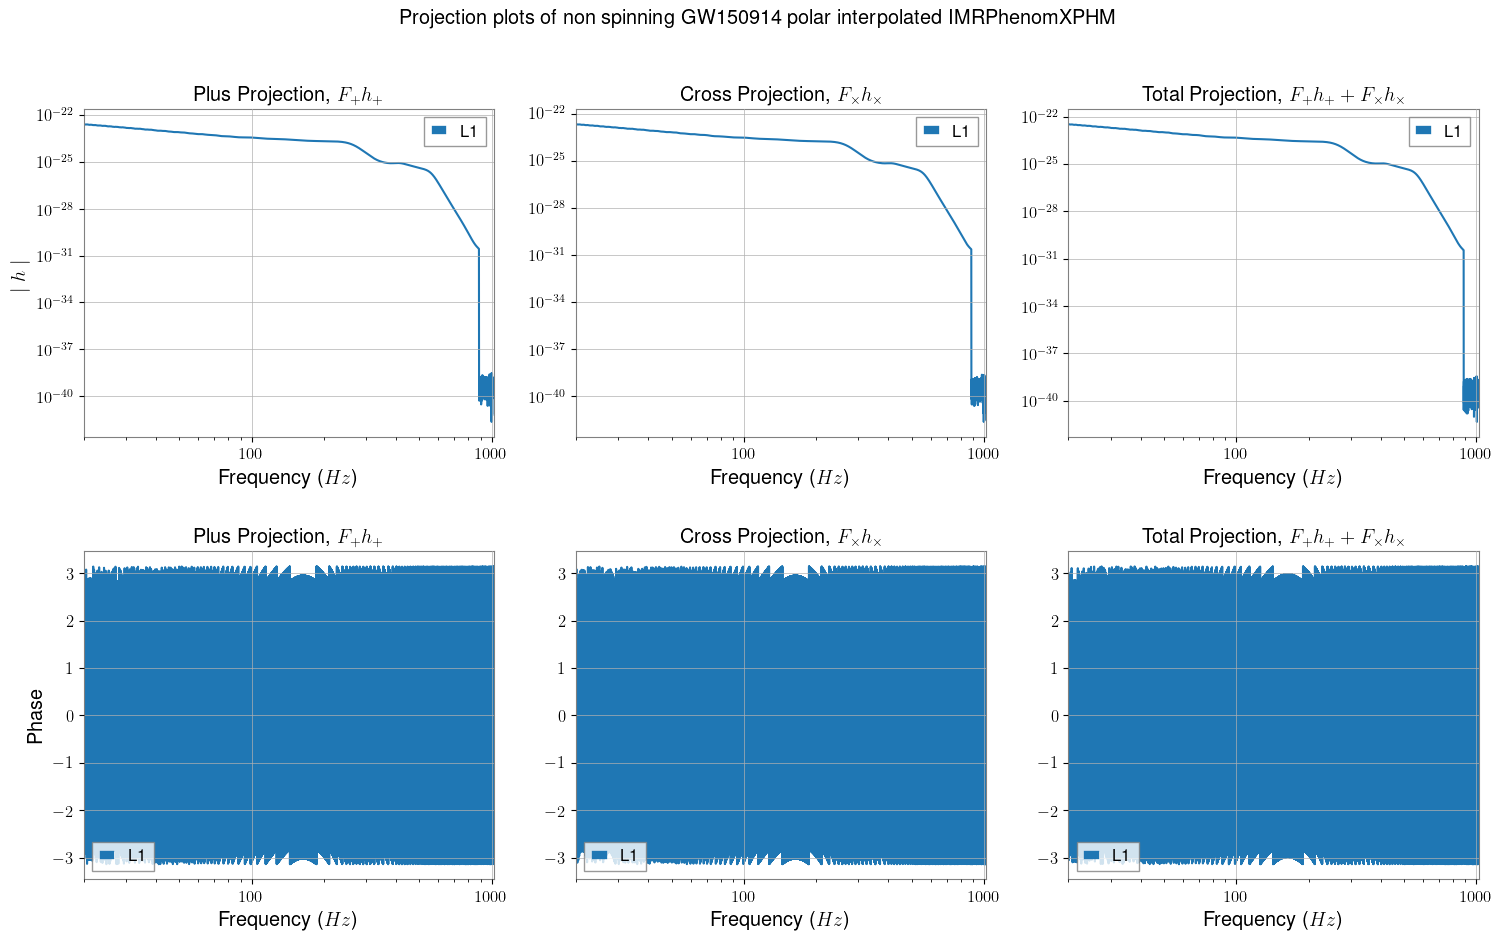

In [58]:
plt.show()

# It works!!!

This interpolation is in normal strain, not in log series

<div class="alert alert-block alert-info">
<b>Tip:</b> The below lines of code is having problem and still haven't checked. 
Please don't consider the below parts of code.
</div>

# How about doing the interpolation in log series to remove spurious effects in lower frequencies

In [59]:
log_strain_array_hp = np.array(f_hp, dtype=np.complex128)
log_strain_array_hc = np.array(f_hc, dtype=np.complex128)

In [60]:
# Absolute strain series
log_abs_strain_hp = np.abs(log_strain_array_hp)
log_abs_strain_hc = np.abs(log_strain_array_hc)

# Converting the log strain into pycbc frequency series to unwrap using PyCBC unwrap
log_f_hp =  pycbc.types.frequencyseries.FrequencySeries(log_strain_array_hp, delta_f=f_hp.delta_f)
log_f_hc =  pycbc.types.frequencyseries.FrequencySeries(log_strain_array_hc, delta_f=f_hc.delta_f)

# Phase series
log_unwrapped_phase_hp = pycbc.waveform.utils.phase_from_frequencyseries(log_f_hp)
log_unwrapped_phase_hc = pycbc.waveform.utils.phase_from_frequencyseries(log_f_hp)
log_unwrapped_phase_strain_hp = np.array(unwrapped_phase_hp)
log_unwrapped_phase_strain_hc = np.array(unwrapped_phase_hc)

In [61]:
if_log_abs_hp = interp1d(f_hp.sample_frequencies[:], log_abs_strain_hp[:], kind='linear')
if_log_abs_hc = interp1d(f_hc.sample_frequencies[:], log_abs_strain_hc[:], kind='linear')

if_log_unwrapped_phase_hp = interp1d(f_hp.sample_frequencies[:], log_unwrapped_phase_strain_hp[:], kind='linear')
if_log_unwrapped_phase_hc = interp1d(f_hc.sample_frequencies[:], log_unwrapped_phase_strain_hc[:], kind='linear')

In [62]:
interpolated_log_abs_hp = np.concatenate(([0], 10**if_log_abs_hp(frequency_vector[1:])))
interpolated_log_abs_hc = np.concatenate(([0], 10**if_log_abs_hc(frequency_vector[1:])))

interpolated_log_unwrapped_phase_hp = np.concatenate(([0], 10**if_log_unwrapped_phase_hp(frequency_vector[1:])))
interpolated_log_unwrapped_phase_hc = np.concatenate(([0], 10**if_log_unwrapped_phase_hc(frequency_vector[1:])))

/tmp/ipykernel_11001/3709194810.py:4: RuntimeWarning: overflow encountered in power
  interpolated_log_unwrapped_phase_hp = np.concatenate(([0], 10**if_log_unwrapped_phase_hp(frequency_vector[1:])))
/tmp/ipykernel_11001/3709194810.py:5: RuntimeWarning: overflow encountered in power
  interpolated_log_unwrapped_phase_hc = np.concatenate(([0], 10**if_log_unwrapped_phase_hc(frequency_vector[1:])))


In [63]:
interpolated_log_unwrapped_polar_hp = interpolated_log_abs_hp*np.exp(1j*interpolated_log_unwrapped_phase_hp)
interpolated_log_unwrapped_polar_hc = interpolated_log_abs_hc*np.exp(1j*interpolated_log_unwrapped_phase_hc)

/tmp/ipykernel_11001/3605487376.py:1: RuntimeWarning: invalid value encountered in multiply
  interpolated_log_unwrapped_polar_hp = interpolated_log_abs_hp*np.exp(1j*interpolated_log_unwrapped_phase_hp)
/tmp/ipykernel_11001/3605487376.py:1: RuntimeWarning: invalid value encountered in exp
  interpolated_log_unwrapped_polar_hp = interpolated_log_abs_hp*np.exp(1j*interpolated_log_unwrapped_phase_hp)
/tmp/ipykernel_11001/3605487376.py:2: RuntimeWarning: invalid value encountered in multiply
  interpolated_log_unwrapped_polar_hc = interpolated_log_abs_hc*np.exp(1j*interpolated_log_unwrapped_phase_hc)
/tmp/ipykernel_11001/3605487376.py:2: RuntimeWarning: invalid value encountered in exp
  interpolated_log_unwrapped_polar_hc = interpolated_log_abs_hc*np.exp(1j*interpolated_log_unwrapped_phase_hc)


In [64]:
frequency_bounds = (frequency_vector >=frequency_vector[0]) * (frequency_vector <= frequency_vector[-1])
interpolated_log_unwrapped_polar_hp *= frequency_bounds
interpolated_log_unwrapped_polar_hp *= frequency_bounds

Let's plot them and check

In [65]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_1 = fig.add_subplot(1,2,1)
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_log_unwrapped_polar_hp), label=r'$h_{+}$')
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_log_unwrapped_polar_hp), label=r'$h_{\times}$')
sub_figure_1.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(1,2,2)
sub_figure_2.plot(frequency_vector, np.angle(interpolated_log_unwrapped_polar_hp), label=r'$h_{+}$')
sub_figure_2.plot(frequency_vector, np.angle(interpolated_log_unwrapped_polar_hp), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xscale('log')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'Phase')
sub_figure_2.legend()

plt.suptitle(r'Interpolated waveform using absolute and unwrapped phase series of non spinning GW150914 IMRPhenomXPHM waveform')

Text(0.5, 0.98, 'Interpolated waveform using absolute and unwrapped phase series of non spinning GW150914 IMRPhenomXPHM waveform')

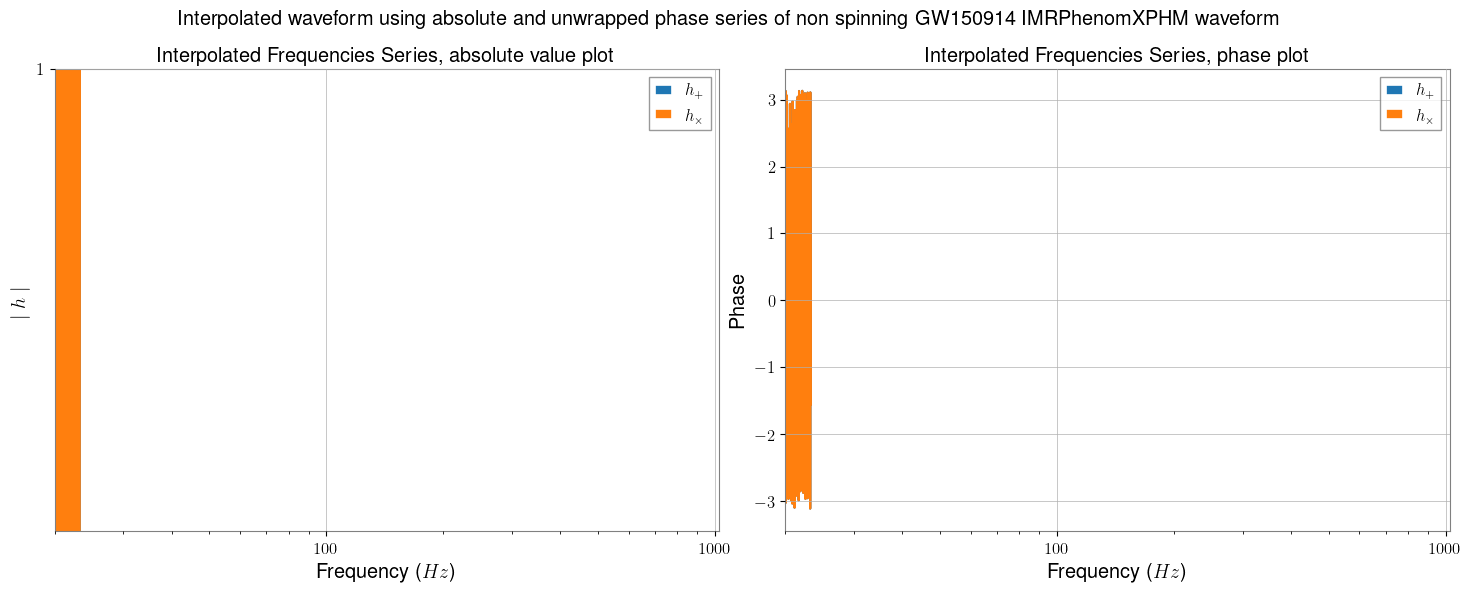

In [66]:
plt.show()

<font size="5"> Checking the match between the two waveforms </font>

In [67]:
interpolated_log_unwrapped_polar_pycbc_hp =  pycbc.types.frequencyseries.FrequencySeries(interpolated_log_unwrapped_polar_hp, delta_f=0.01)
interpolated_log_unwrapped_polar_pycbc_hc =  pycbc.types.frequencyseries.FrequencySeries(interpolated_log_unwrapped_polar_hc, delta_f=0.01)

In [68]:
print("The match between the (plus) interpolated waveform and the generated waveform is ", match(interpolated_log_unwrapped_polar_pycbc_hp, f_hp_001)[0])
print("The match between the (cross) interpolated waveform and the generated waveform is ", match(interpolated_log_unwrapped_polar_pycbc_hc, f_hc_001)[0])

The match between the (plus) interpolated waveform and the generated waveform is  nan
The match between the (cross) interpolated waveform and the generated waveform is  nan


This has a better interpolation!!

Let's check the projection for this type of interpolation

In [69]:
proj_interpolated_log_unwrapped_polar_hp = fp*interpolated_log_unwrapped_polar_hp
proj_interpolated_log_unwrapped_polar_hc = fc*interpolated_log_unwrapped_polar_hc
tot_proj_interpolated_log_unwrapped_polar = proj_interpolated_log_unwrapped_polar_hp + proj_interpolated_log_unwrapped_polar_hc

In [70]:
fig = plt.figure(figsize=(18, 10))
# plt.subplots_adjust(wspace= 0.1, hspace= 0.25)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

sub_figure_1 = fig.add_subplot(2,3,1)
sub_figure_1.loglog(frequency_vector, np.abs(proj_interpolated_log_unwrapped_polar_hp), label=r'L1')
sub_figure_1.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()
# sub_figure_1.text(x = 0, y = 0, s = r'\textbf{Absolute value plots}', rotation=90)

sub_figure_2 = fig.add_subplot(2,3,2)
sub_figure_2.loglog(frequency_vector, np.abs(proj_interpolated_log_unwrapped_polar_hc), label=r'L1')
sub_figure_2.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
# sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,3,3)
sub_figure_3.loglog(frequency_vector, np.abs(tot_proj_interpolated_log_unwrapped_polar), label=r'L1')
sub_figure_3.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xlim(20, 1024)
# sub_figure_3.set_ylabel(r'$\mid h \mid$')
sub_figure_3.legend()

sub_figure_4 = fig.add_subplot(2,3,4)
sub_figure_4.plot(frequency_vector, np.angle(proj_interpolated_log_unwrapped_polar_hp), label=r'L1')
sub_figure_4.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_4.set_xlabel(r'Frequency ($Hz$)')
sub_figure_4.set_xscale('log')
sub_figure_4.set_xlim(20, 1024)
sub_figure_4.set_ylabel(r'Phase')
sub_figure_4.legend()
# sub_figure_4.text(x = 0, y = 0, s = r'\textbf{Phase value plots}', rotation=90)

sub_figure_5 = fig.add_subplot(2,3,5)
sub_figure_5.plot(frequency_vector, np.angle(proj_interpolated_log_unwrapped_polar_hc), label=r'L1')
sub_figure_5.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_5.set_xlabel(r'Frequency ($Hz$)')
sub_figure_5.set_xscale('log')
sub_figure_5.set_xlim(20, 1024)
# sub_figure_5.set_ylabel(r'Phase')
sub_figure_5.legend()

sub_figure_6 = fig.add_subplot(2,3,6)
sub_figure_6.plot(frequency_vector, np.angle(tot_proj_interpolated_log_unwrapped_polar), label=r'L1')
sub_figure_6.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_6.set_xlabel(r'Frequency ($Hz$)')
sub_figure_6.set_xscale('log')
sub_figure_6.set_xlim(20, 1024)
# sub_figure_6.set_ylabel(r'Phase')
sub_figure_6.legend()

plt.suptitle(r'Projection plots of non spinning GW150914 polar interpolated IMRPhenomXPHM')
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

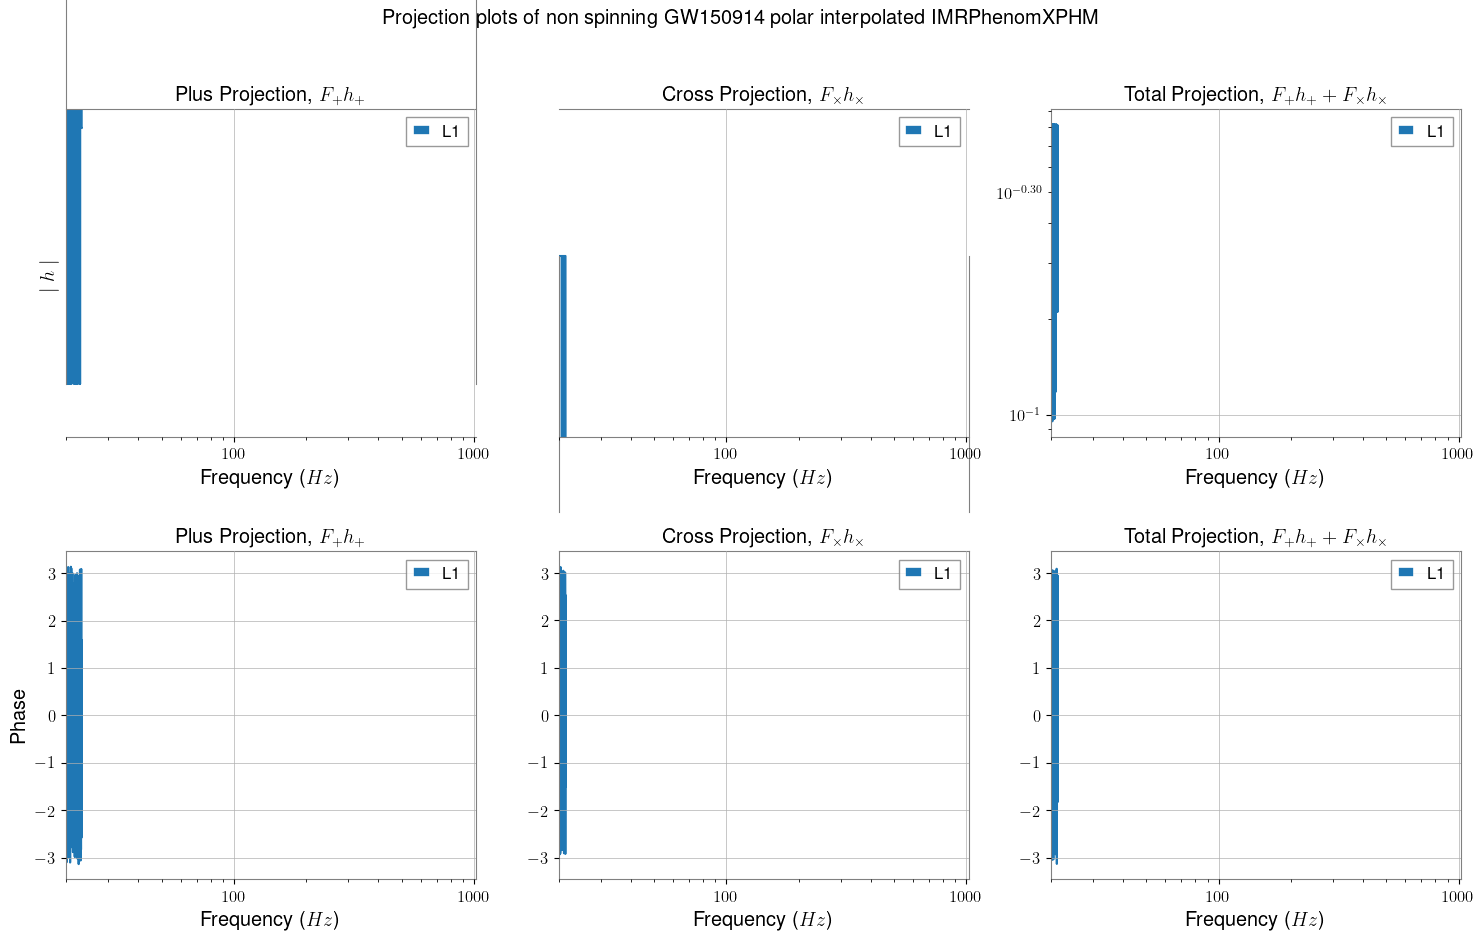

In [71]:
plt.show()